In [1]:
from netCDF4 import Dataset
import numpy as np
import sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from tqdm import tqdm

In [2]:
# load data
airTemp = '../../global-longrun_jedi-dvgm_inputs_outputs/tas.nc'
netLongRadiantionFlux = '../../global-longrun_jedi-dvgm_inputs_outputs/rlns.nc'
shortwaveRadiation = '../../global-longrun_jedi-dvgm_inputs_outputs/rsds.nc'
precipitation = '../../global-longrun_jedi-dvgm_inputs_outputs/pr.nc'
output = '../../global-longrun_jedi-dvgm_inputs_outputs/jedi_output.nc'

landSeaMask = '../../global-longrun_jedi-dvgm_inputs_outputs/landsea.nc'
lantitude =  '../../global-longrun_jedi-dvgm_inputs_outputs/latitude.nc'
longitude = '../../global-longrun_jedi-dvgm_inputs_outputs/longitude.nc'
elevation = '../../global-longrun_jedi-dvgm_inputs_outputs/elevation.nc'
moisture = '../../global-longrun_jedi-dvgm_inputs_outputs/paw.nc'
spatialMetaData = '../../global-longrun_jedi-dvgm_inputs_outputs/globe_surf.nc'

airTempDataset = Dataset(airTemp)
netLongRadiantionFluxDataSet = Dataset(netLongRadiantionFlux)
shortwaveRadiationDataset = Dataset(shortwaveRadiation)
precipitationDataSet = Dataset(precipitation)
outputDataset = Dataset(output)

landSeaMaskDataset = Dataset(landSeaMask)
lantitudeDataset = Dataset(lantitude)
longitudeDataset = Dataset(longitude)
elevationDataset = Dataset(elevation)
moistureDataset = Dataset(moisture)
spatialMetaDataset = Dataset(spatialMetaData)

airTempArray = airTempDataset['tas'][:].squeeze()
netLongRadiantionFluxArray = netLongRadiantionFluxDataSet['rlns'][:].squeeze()
shortwaveRadiationArray = shortwaveRadiationDataset['rsds'][:].squeeze()
precipitationArray = precipitationDataSet['pr'][:].squeeze()
NPPArray = outputDataset['NPP'][:].squeeze()
landSeaMaskArray = landSeaMaskDataset['var1'][:].squeeze()
lantitudeArray = lantitudeDataset['lat'][:].squeeze()
longitudeArray = longitudeDataset['lon'][:].squeeze()
elevationArray = elevationDataset['data'][:].squeeze()
moistureArray = moistureDataset['paw'][:].squeeze()
spatialMetaDataArray = spatialMetaDataset['lev']



In [3]:
print('airTempArray'+str(np.shape(airTempArray)))
print('netLongRadiantionFluxArray'+str(np.shape(netLongRadiantionFluxArray)))
print('shortwaveRadiationArray'+str(np.shape(shortwaveRadiationArray)))
print('precipitationArray'+str(np.shape(precipitationArray)))
print('NPPArray'+str(np.shape(NPPArray)))
print('landSeaMaskArray'+str(np.shape(landSeaMaskArray)))
print('lantitudeArray'+str(np.shape(lantitudeArray)))
print('longitudeArray'+str(np.shape(longitudeArray)))
print('elevationArray'+str(np.shape(elevationArray)))
print('moistureArray'+str(np.shape(moistureArray)))
print('spatialMetaDataArray'+str(np.shape(spatialMetaDataArray)))

airTempArray(3516, 145, 192)
netLongRadiantionFluxArray(3516, 145, 192)
shortwaveRadiationArray(3516, 145, 192)
precipitationArray(3516, 145, 192)
NPPArray(3516, 145, 192)
landSeaMaskArray(145, 192)
lantitudeArray(145,)
longitudeArray(192,)
elevationArray(145, 192)
moistureArray(145, 192)
spatialMetaDataArray()


In [4]:
# process time series data 
airTempArray_flatten= airTempArray.reshape(3516*145*192)
netLongRadiantionFluxArray_flatten= netLongRadiantionFluxArray.reshape(3516*145*192)
shortwaveRadiationArray_flatten= shortwaveRadiationArray.reshape(3516*145*192)
precipitationArray_flatten= precipitationArray.reshape(3516*145*192)
NPPArray_flatten= NPPArray.reshape(3516*145*192)

In [5]:
geo_data_dict = {'airTempArray':airTempArray_flatten, 'netLongRadiantionFluxArray':netLongRadiantionFluxArray_flatten,
"shortwaveRadiationArray": shortwaveRadiationArray_flatten, "precipitationArray" :precipitationArray_flatten, "NPPArray": NPPArray_flatten}
geo_data = pd.DataFrame(geo_data_dict).values.reshape(3516,145*192*5).transpose((1,0))
new_time = pd.DataFrame(geo_data)

In [6]:
# delete rows which is "nan"
label = []
for i in range(len(new_time)):
    if str(new_time.iloc[i,0]) == 'nan':
        label.append(i)
print(len(label))
for i in range(len(label)):
    for j in range(label[i]-4,label[i]+1):
        new_time = new_time.drop(j)
new_time

0


,0,1,2,3,4,5,6,7,8,9,...,3506,3507,3508,3509,3510,3511,3512,3513,3514,3515
0,255.376709,241.980713,217.620972,218.278687,2.129109e+02,216.666382,210.956421,210.495300,2.107073e+02,226.093445,...,218.774414,216.018799,220.278137,216.572388,2.127487e+02,213.778992,211.101562,223.092651,243.997620,258.939697
1,-87.062500,-54.882812,-27.625000,-16.460938,-2.678125e+01,-21.218750,-20.187500,-20.851562,-3.079688e+01,-36.070312,...,-25.500000,-18.648438,-20.656250,-24.679688,-3.032031e+01,-18.773438,-21.781250,-40.710938,-64.203125,-84.953125
2,393.575195,209.866745,33.513439,0.000000,0.000000e+00,0.000000,0.000000,0.000000,5.113512e+00,130.489410,...,34.327927,0.000000,0.000000,0.000000,0.000000e+00,0.000000,4.448794,147.108505,306.039948,415.767487
3,0.000002,0.000003,0.000001,0.000003,9.578346e-07,0.000002,0.000001,0.000001,4.837670e-07,0.000002,...,0.000001,0.000002,0.000003,0.000002,6.975051e-07,0.000001,0.000001,0.000001,0.000003,0.000003
4,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139195,246.105652,242.742126,244.940735,253.403137,2.639419e+02,272.731445,272.910156,271.371338,2.649944e+02,255.461182,...,240.007324,250.320435,262.696045,272.684814,2.726499e+02,271.637939,270.729004,264.071533,255.815979,247.348450
139196,-35.039062,-34.023438,-32.351562,-41.453125,-5.482031e+01,-22.593750,-19.679688,-30.812500,-3.835938e+01,-35.968750,...,-35.445312,-46.781250,-66.218750,-29.351562,-1.582812e+01,-9.242188,-28.867188,-36.101562,-46.062500,-44.945312
139197,0.000000,0.000000,7.936532,129.621887,2.740091e+02,280.992767,228.310181,131.820648,2.777876e+01,0.000000,...,8.147499,137.829300,301.351685,274.785950,2.213789e+02,106.561874,22.486742,0.000000,0.000000,0.000000
139198,0.000008,0.000004,0.000007,0.000009,7.784894e-06,0.000006,0.000013,0.000016,1.159471e-05,0.000011,...,0.000002,0.000004,0.000003,0.000013,1.288522e-05,0.000017,0.000015,0.000016,0.000007,0.000005


In [7]:
new_time_year = pd.DataFrame()
for i in range(int(len(new_time.columns)/12)):
    data_average=np.mean(new_time.iloc[:,12*i:12*(i+1)], axis=1)
    new_time_year[i]=data_average
new_time_year

,0,1,2,3,4,5,6,7,8,9,...,283,284,285,286,287,288,289,290,291,292
0,226.518524,227.438059,228.497838,226.653509,227.644669,228.047821,228.224818,227.976507,228.497294,227.404750,...,228.936157,229.561218,228.465973,227.987869,227.171137,228.341588,229.295456,229.876582,228.272807,227.528519
1,-41.811849,-43.830078,-42.614583,-40.739583,-40.330078,-41.044271,-39.247396,-42.079427,-40.709635,-39.873047,...,-40.783203,-40.675130,-41.331380,-39.406250,-40.856771,-42.707031,-39.313802,-40.578125,-39.688802,-42.213542
2,127.631634,131.303673,128.883474,130.113528,127.668338,128.079901,129.376294,130.747346,131.396810,128.782424,...,128.807542,128.092076,128.148680,125.764945,126.218755,128.621842,125.241451,127.799725,126.280551,127.946854
3,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000002,0.000003,0.000002,0.000002,0.000002,0.000002,0.000003,0.000003,0.000003,0.000002
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139195,256.936793,256.991358,256.286062,256.126775,256.004522,255.683477,257.558533,258.257899,258.026794,258.351578,...,259.914352,258.867671,258.718053,256.703761,257.879532,257.844309,258.305110,257.292653,258.441289,258.116821
139196,-34.385417,-36.880859,-36.495443,-38.479818,-35.753906,-36.462891,-36.940104,-35.881510,-37.274089,-36.328776,...,-40.195964,-39.361328,-37.550130,-39.117839,-37.449870,-39.690755,-38.900391,-37.415365,-35.271484,-36.264974
139197,90.039156,86.025670,91.778164,91.066148,89.577249,93.680996,92.476794,87.427493,91.677881,91.736955,...,86.803147,89.504421,83.804328,90.781403,88.918383,87.924706,93.656857,93.222612,88.363021,89.378494
139198,0.000009,0.000009,0.000007,0.000006,0.000009,0.000006,0.000008,0.000009,0.000008,0.000009,...,0.000010,0.000009,0.000009,0.000007,0.000008,0.000010,0.000009,0.000008,0.000010,0.000009


In [8]:
# remove data where all 293 year's NPP is 0
zero_index = []
for i in range(int(len(new_time_year)/5)):
    if new_time_year.iloc[i*5+4:i*5+5,:].sum(axis=1).values[0] == 0:
        zero_index.append(i*5)
        zero_index.append(i*5+1)
        zero_index.append(i*5+2)
        zero_index.append(i*5+3)
        zero_index.append(i*5+4)

In [9]:
new_time_year = new_time_year.drop(zero_index)

In [10]:
new_time_year.index = range(len(new_time_year))
new_time_year

,0,1,2,3,4,5,6,7,8,9,...,283,284,285,286,287,288,289,290,291,292
0,259.569295,257.779251,261.612437,259.805583,259.517125,257.122696,258.397868,258.196055,259.226817,258.507456,...,260.849264,262.001745,259.209213,258.110860,255.900879,258.236837,258.845240,261.618429,262.683507,259.706863
1,-58.531250,-59.554688,-53.106120,-58.130208,-53.305990,-54.369792,-56.777344,-51.250651,-52.848958,-52.965495,...,-58.836589,-59.484375,-50.693359,-52.104818,-57.842448,-53.647786,-57.591797,-55.649089,-57.401042,-52.932292
2,121.298479,127.786171,105.556902,116.030153,119.126147,118.707997,115.120953,114.994855,121.208494,110.430552,...,118.350818,117.757287,113.998104,110.592406,113.733111,122.374279,117.563152,116.946420,117.737973,115.723693
3,0.000010,0.000012,0.000019,0.000015,0.000015,0.000011,0.000013,0.000015,0.000016,0.000015,...,0.000015,0.000014,0.000019,0.000017,0.000010,0.000012,0.000013,0.000019,0.000017,0.000016
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40460,271.042180,272.195791,271.917292,272.672750,271.172414,271.815928,271.685216,272.721039,273.843847,274.295441,...,274.602453,275.218175,274.066071,273.395437,275.199346,273.942586,273.276057,272.998520,273.084910,272.404867
40461,-36.747396,-37.533854,-37.666016,-34.920573,-38.606120,-38.881510,-35.882161,-32.510417,-32.961589,-33.811198,...,-36.940755,-34.843099,-37.481120,-33.783854,-33.706380,-38.500000,-35.619141,-36.873047,-36.059245,-33.393229
40462,113.727249,114.987738,104.334452,108.067668,119.969709,109.294378,113.584221,106.853343,109.937563,109.004480,...,113.425759,106.819738,112.613226,105.826578,109.837650,114.053178,109.399938,116.805576,110.370550,111.898399
40463,0.000026,0.000028,0.000037,0.000033,0.000033,0.000030,0.000030,0.000031,0.000035,0.000038,...,0.000032,0.000032,0.000032,0.000038,0.000036,0.000038,0.000035,0.000028,0.000035,0.000036


In [11]:
# Try all_features + NPP
new_time_year_allfeatures_NPP = pd.DataFrame()
for i in range(int(len(new_time_year)/5)):
    temp = pd.DataFrame(pd.concat([new_time_year.iloc[i*5,:],new_time_year.iloc[i*5+1,:],new_time_year.iloc[i*5+2,:],new_time_year.iloc[i*5+3,:],new_time_year.iloc[i*5+4,:]], axis = 0))
    temp.index = range(len(temp))
    new_time_year_allfeatures_NPP  = pd.concat([new_time_year_allfeatures_NPP, temp.T])
    

In [12]:
# split train set and test set
x_train_year_dynamic, x_test_year_dynamic, y_train_year_dynamic, y_test_year_dynamic = train_test_split(new_time_year_allfeatures_NPP.iloc[:,0:1461], 
                                                    new_time_year_allfeatures_NPP.iloc[:,1461:], random_state=2, train_size=0.8)
                                                    

100%|██████████| 4/4 [38:09<00:00, 572.44s/it]

Best tree number: 90
Highest accuracy: 0.8645


Text(0.5, 1.0, 'Allfeatures + NPP')

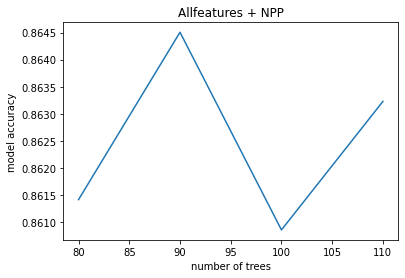

In [13]:
# RandomForest：select best tree number which has highest accuracy (npp data)
rf_value = []
best_tree_number = 0
max_v = 0
for i in tqdm(range(80,120,10)):
    model_randomforest = ensemble.RandomForestRegressor(n_estimators=i)
    model_randomforest.fit(x_train_year_dynamic, y_train_year_dynamic)
    predict_score = model_randomforest.score(x_test_year_dynamic, y_test_year_dynamic)
    if predict_score > max_v:
        max_v = predict_score 
        best_tree_number = i
    rf_value.append(predict_score)
tree_number = [i for i in range(80,120,10)]
print("Best tree number:", best_tree_number)
print("Highest accuracy:", round(max_v,4))
plt.plot(tree_number,rf_value)
plt.xlabel("number of trees")
plt.ylabel("model accuracy")
plt.title("Allfeatures + NPP")

MSE Train: 0.014, Test: 0.104
R2_Score Train: 0.981, Test: 0.863


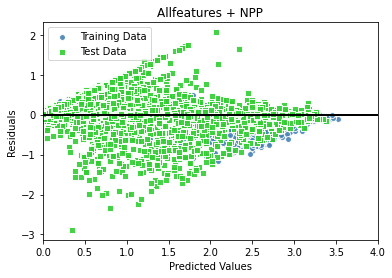

In [14]:
# show scatter plot, mse and r2_square
from sklearn.metrics import mean_squared_error,r2_score
y_train_pred=model_randomforest.predict(x_train_year_dynamic)
y_test_pred=model_randomforest.predict(x_test_year_dynamic)

print("MSE Train: %.3f, Test: %.3f" % (mean_squared_error(y_train_year_dynamic,y_train_pred),
                                       mean_squared_error(y_test_year_dynamic,y_test_pred)))
print("R2_Score Train: %.3f, Test: %.3f" % (r2_score(y_train_year_dynamic,y_train_pred),
                                            r2_score(y_test_year_dynamic,y_test_pred)))

plt.scatter(y_train_pred,y_train_pred-y_train_year_dynamic,
            c='steelblue',
            edgecolor='white',
            marker='o',
            s=35,
            alpha=0.9,
            label='Training Data')
plt.scatter(y_test_pred,y_test_pred-y_test_year_dynamic,
            c='limegreen',
            edgecolor='white',
            marker='s',
            s=35,
            alpha=0.9,
            label='Test Data')

plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Allfeatures + NPP")
plt.legend(loc='upper left')
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color='black')
plt.xlim([0,4])
plt.savefig('./fig1.png')
plt.show()
